<a href="https://colab.research.google.com/github/Servat0r/Robotics-Project/blob/master/notebooks/Scaling_and_extra_hidden_layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Fine-tuned VGG16 and VGG19

In [ ]:
%cd "/content/drive/MyDrive/Colab Notebooks"

/content/drive/MyDrive/Colab Notebooks


In [ ]:
import numpy as np
import cv2
from PIL import Image
import os
import PIL
import tensorflow as tf
import tensorflow_datasets as tfds
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import json

In [ ]:
%run utils.ipynb

/content/drive/MyDrive/Colab Notebooks


In [ ]:
train_images, train_tip_pos = [], []
eval_images, eval_tip_pos = [], []
test_images, test_tip_pos = [], []
for i in range(1, 6):
  images, tip_pos = get_dataset(
      f'data/images/{i}', target_size=(224, 224), force_resize=False, rescale_coordinates=100
  )
  (curr_train_images, curr_train_tip_pos), (curr_eval_images, curr_eval_tip_pos), (curr_test_images, curr_test_tip_pos) = \
    holdout_split(0.6, 0.2, 0.2, images, tip_pos)
  del images, tip_pos
  train_images.append(curr_train_images)
  train_tip_pos.append(curr_train_tip_pos)
  eval_images.append(curr_eval_images)
  eval_tip_pos.append(curr_eval_tip_pos)
  test_images.append(curr_test_images)
  test_tip_pos.append(curr_test_tip_pos)

train_images = np.row_stack(train_images)
train_tip_pos = np.row_stack(train_tip_pos)
eval_images = np.row_stack(eval_images)
eval_tip_pos = np.row_stack(eval_tip_pos)
test_images = np.row_stack(test_images)
test_tip_pos = np.row_stack(test_tip_pos)

In [ ]:
print(len(train_images), len(train_tip_pos), len(eval_images))

1535 1535 515


In [ ]:
batch_size = 32  #len(images)
resize_perc = 0.125
n_epochs = 100

#### VGG16

In [ ]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
)
base_model.trainable = False

In [ ]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(3, activation='linear')(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 3)                 75267     
                                                                 
Total params: 14,789,955
Trainable params: 75,267
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
model.compile(
    loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=['mean_absolute_error', mean_euclidean_error]
)

In [ ]:
history = model.fit(
    train_images, train_tip_pos, epochs=n_epochs,
    validation_data=(eval_images, eval_tip_pos),
    batch_size = batch_size, shuffle=True,
)

Epoch 1/100
48/48 [==============================] - 5s 82ms/step - loss: 25.7465 - mean_absolute_error: 3.6774 - mean_euclidean_error: 7.4769 - val_loss: 8.8398 - val_mean_absolute_error: 2.1817 - val_mean_euclidean_error: 4.6084
Epoch 2/100
48/48 [==============================] - 3s 73ms/step - loss: 3.7231 - mean_absolute_error: 1.3272 - mean_euclidean_error: 2.8516 - val_loss: 3.4344 - val_mean_absolute_error: 1.2076 - val_mean_euclidean_error: 2.6083
Epoch 3/100
48/48 [==============================] - 3s 73ms/step - loss: 1.7212 - mean_absolute_error: 0.8659 - mean_euclidean_error: 1.8875 - val_loss: 2.1184 - val_mean_absolute_error: 0.9218 - val_mean_euclidean_error: 1.9693
Epoch 4/100
48/48 [==============================] - 3s 70ms/step - loss: 1.1646 - mean_absolute_error: 0.7101 - mean_euclidean_error: 1.5494 - val_loss: 1.6789 - val_mean_absolute_error: 0.8308 - val_mean_euclidean_error: 1.7820
Epoch 5/100
48/48 [==============================] - 4s 78ms/step - loss: 0.980

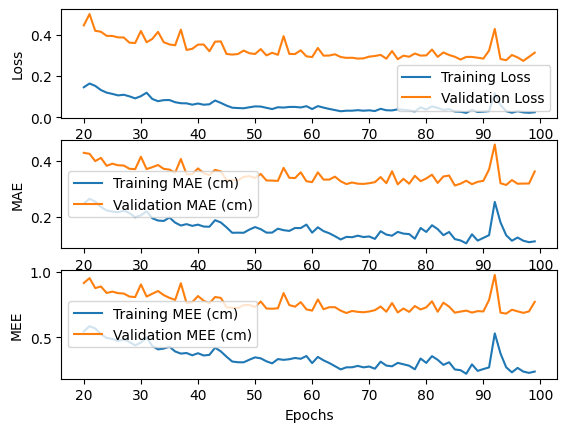

In [ ]:
plot_metrics(
    history, start_epoch=20, end_epoch=None,
    metrics=['loss', 'mean_absolute_error', 'mean_euclidean_error'],
    data_labels=[
        ('Training Loss', 'Validation Loss'), ('Training MAE (cm)', 'Validation MAE (cm)'),
        ('Training MEE (cm)', 'Validation MEE (cm)')
    ],
    axes_labels=[
        ('Epochs', 'Loss'), ('Epochs', 'MAE'), ('Epochs', 'MEE')
    ]
)

17/17 [==============================] - 1s 40ms/step
515 515 515
515 515 515
x-axis: mean = 0.3563470206350857, std = 1.3727762849731038
y-axis: mean = 0.0834078603344008, std = 0.3421035141306793
z-axis: mean = 0.014077296936475196, std = 0.017080600023362254


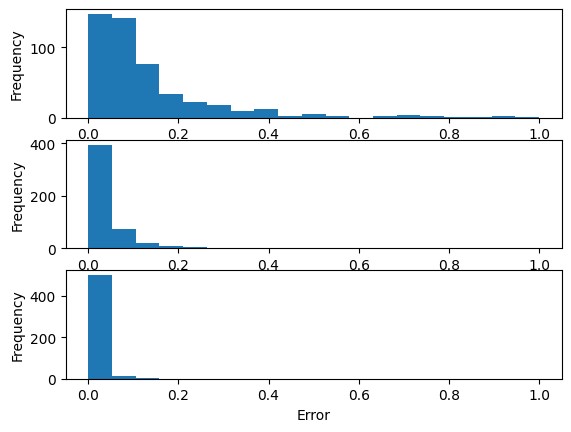

In [ ]:
epsilon = 1e-12
predictions = model.predict(eval_images)
plot_relative_errors(predictions, eval_tip_pos, epsilon, max_error=1, nbins=20)

...

We now calculate also mean and standard deviation of loss, absolute and euclidean errors:

In [ ]:
mean_absolute_errors = tf.keras.metrics.mean_absolute_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MAE: {np.mean(mean_absolute_errors)}')
print(f'Std of MAE: {np.std(mean_absolute_errors)}')

mean_euclidean_errors = mean_euclidean_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MEE: {np.mean(mean_euclidean_errors)}')
print(f'Std of MEE: {np.std(mean_euclidean_errors)}')

Mean of MAE: 0.36126598715782166
Std of MAE: 0.2575026750564575
Mean of MEE: 0.7722617273287947
Std of MEE: 0.5852853677582479


We calculate them also along each axis:

In [ ]:
distances = np.abs(eval_tip_pos - predictions)
print(f'Mean Distance along axes: {np.mean(distances, axis=0)}')
print(f'Std of Distance along axes: {np.std(distances, axis=0)}')

Mean Distance along axes: [0.63155831 0.22372734 0.22851232]
Std of Distance along axes: [0.59606748 0.21154244 0.19432651]


Now we save model and history:

In [ ]:
model.save('finetunedVGG165130NonRandomizedDataset')

In [ ]:
json.dump(history.history, open('finetunedVGG165130NonRandomizedDataset.json', 'w'))

In [ ]:
del model

#### VGG16 with scaler (meters)

In [ ]:
train_mean, train_std = np.mean(train_tip_pos), np.mean(eval_tip_pos)

In [ ]:
train_tip_pos_bak = train_tip_pos.copy()

In [ ]:
train_tip_pos = (train_tip_pos - train_mean) / train_std
eval_tip_pos = (eval_tip_pos - train_mean) / (train_std)

In [ ]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
)
base_model.trainable = False

In [ ]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(3, activation='linear')(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 3)                 75267     
                                                                 
Total params: 14,789,955
Trainable params: 75,267
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
model.compile(
    loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=['mean_absolute_error', mean_euclidean_error]
)

In [ ]:
history = model.fit(
    train_images, train_tip_pos, epochs=n_epochs,
    validation_data=(eval_images, eval_tip_pos),
    batch_size = batch_size, shuffle=True,
)

Epoch 1/100
48/48 [==============================] - 5s 90ms/step - loss: 0.9098 - mean_absolute_error: 0.6607 - mean_euclidean_error: 1.3114 - val_loss: 0.0882 - val_mean_absolute_error: 0.2164 - val_mean_euclidean_error: 0.4433
Epoch 2/100
48/48 [==============================] - 3s 73ms/step - loss: 0.0410 - mean_absolute_error: 0.1480 - mean_euclidean_error: 0.3072 - val_loss: 0.0372 - val_mean_absolute_error: 0.1374 - val_mean_euclidean_error: 0.2848
Epoch 3/100
48/48 [==============================] - 4s 74ms/step - loss: 0.0228 - mean_absolute_error: 0.1078 - mean_euclidean_error: 0.2279 - val_loss: 0.0302 - val_mean_absolute_error: 0.1197 - val_mean_euclidean_error: 0.2522
Epoch 4/100
48/48 [==============================] - 3s 73ms/step - loss: 0.0144 - mean_absolute_error: 0.0849 - mean_euclidean_error: 0.1797 - val_loss: 0.0225 - val_mean_absolute_error: 0.1002 - val_mean_euclidean_error: 0.2120
Epoch 5/100
48/48 [==============================] - 3s 61ms/step - loss: 0.0110

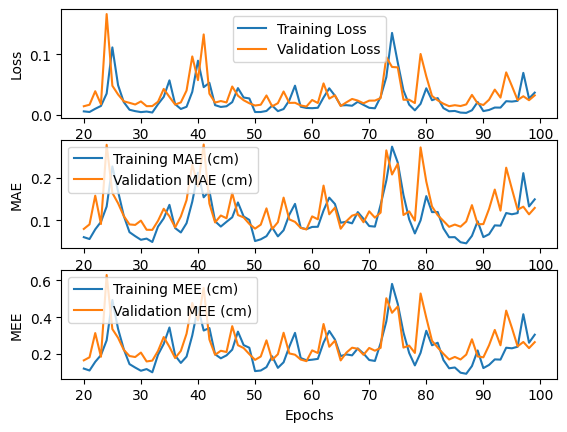

In [ ]:
plot_metrics(
    history, start_epoch=20, end_epoch=None,
    metrics=['loss', 'mean_absolute_error', 'mean_euclidean_error'],
    data_labels=[
        ('Training Loss', 'Validation Loss'), ('Training MAE (cm)', 'Validation MAE (cm)'),
        ('Training MEE (cm)', 'Validation MEE (cm)')
    ],
    axes_labels=[
        ('Epochs', 'Loss'), ('Epochs', 'MAE'), ('Epochs', 'MEE')
    ]
)

17/17 [==============================] - 1s 46ms/step
515 515 515
515 515 515
x-axis: mean = 0.46613239792461386, std = 2.2516149084467876
y-axis: mean = 0.26766148826740715, std = 0.6355929091059448
z-axis: mean = 0.054595754610382005, std = 0.06258752558595687


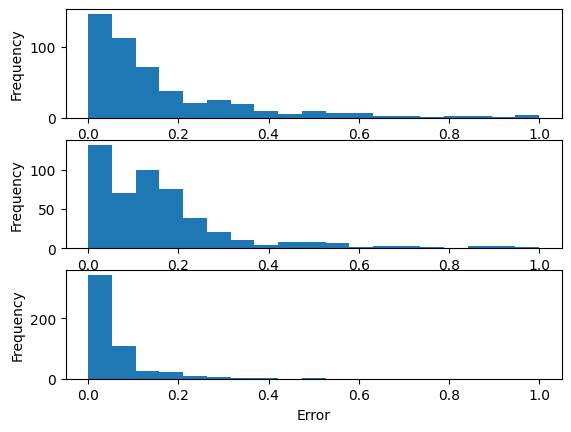

In [ ]:
epsilon = 1e-12
predictions = model.predict(eval_images)
plot_relative_errors(predictions, eval_tip_pos, epsilon, max_error=1, nbins=20)

...

We now calculate also mean and standard deviation of loss, absolute and euclidean errors:

In [ ]:
mean_absolute_errors = tf.keras.metrics.mean_absolute_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MAE: {np.mean(mean_absolute_errors)}')
print(f'Std of MAE: {np.std(mean_absolute_errors)}')

mean_euclidean_errors = mean_euclidean_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MEE: {np.mean(mean_euclidean_errors)}')
print(f'Std of MEE: {np.std(mean_euclidean_errors)}')

Mean of MAE: 0.1291055977344513
Std of MAE: 0.07780653238296509
Mean of MEE: 0.264730239030853
Std of MEE: 0.1656765416347998


We calculate them also along each axis:

In [ ]:
distances = np.abs(eval_tip_pos - predictions)
print(f'Mean Distance along axes: {np.mean(distances, axis=0)}')
print(f'Std of Distance along axes: {np.std(distances, axis=0)}')

Mean Distance along axes: [0.1318965  0.16786734 0.08755294]
Std of Distance along axes: [0.13650032 0.14285663 0.0724487 ]


Now we save model and history:

In [ ]:
model.save('finetunedVGG165130NonRandomizedDatasetScaled')

In [ ]:
json.dump(history.history, open('finetunedVGG165130NonRandomizedDatasetScaled.json', 'w'))

In [ ]:
del model

##### With a lower learning rate

In [ ]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
)
base_model.trainable = False

In [ ]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(3, activation='linear')(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 3)                 75267     
                                                                 
Total params: 14,789,955
Trainable params: 75,267
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
model.compile(
    loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4),
    metrics=['mean_absolute_error', mean_euclidean_error]
)

In [ ]:
history = model.fit(
    train_images, train_tip_pos, epochs=n_epochs,
    validation_data=(eval_images, eval_tip_pos),
    batch_size = batch_size, shuffle=True,
)

Epoch 1/100
48/48 [==============================] - 5s 77ms/step - loss: 0.6782 - mean_absolute_error: 0.5919 - mean_euclidean_error: 1.2039 - val_loss: 0.2402 - val_mean_absolute_error: 0.3439 - val_mean_euclidean_error: 0.7440
Epoch 2/100
48/48 [==============================] - 4s 76ms/step - loss: 0.1055 - mean_absolute_error: 0.2260 - mean_euclidean_error: 0.4835 - val_loss: 0.1021 - val_mean_absolute_error: 0.2179 - val_mean_euclidean_error: 0.4590
Epoch 3/100
48/48 [==============================] - 3s 62ms/step - loss: 0.0505 - mean_absolute_error: 0.1572 - mean_euclidean_error: 0.3336 - val_loss: 0.0626 - val_mean_absolute_error: 0.1700 - val_mean_euclidean_error: 0.3547
Epoch 4/100
48/48 [==============================] - 4s 78ms/step - loss: 0.0335 - mean_absolute_error: 0.1263 - mean_euclidean_error: 0.2691 - val_loss: 0.0450 - val_mean_absolute_error: 0.1415 - val_mean_euclidean_error: 0.2966
Epoch 5/100
48/48 [==============================] - 4s 74ms/step - loss: 0.0255

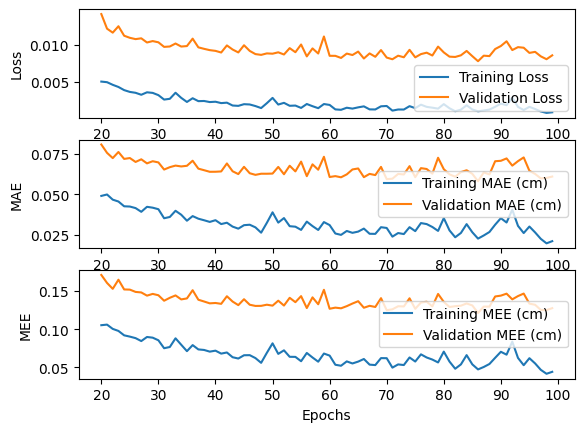

In [ ]:
plot_metrics(
    history, start_epoch=20, end_epoch=None,
    metrics=['loss', 'mean_absolute_error', 'mean_euclidean_error'],
    data_labels=[
        ('Training Loss', 'Validation Loss'), ('Training MAE (cm)', 'Validation MAE (cm)'),
        ('Training MEE (cm)', 'Validation MEE (cm)')
    ],
    axes_labels=[
        ('Epochs', 'Loss'), ('Epochs', 'MAE'), ('Epochs', 'MEE')
    ]
)

17/17 [==============================] - 1s 41ms/step
515 515 515
515 515 515
x-axis: mean = 0.3080799851227308, std = 1.3772086618026211
y-axis: mean = 0.0777265452065078, std = 0.17506317341001765
z-axis: mean = 0.03352185166566942, std = 0.08386000793628351


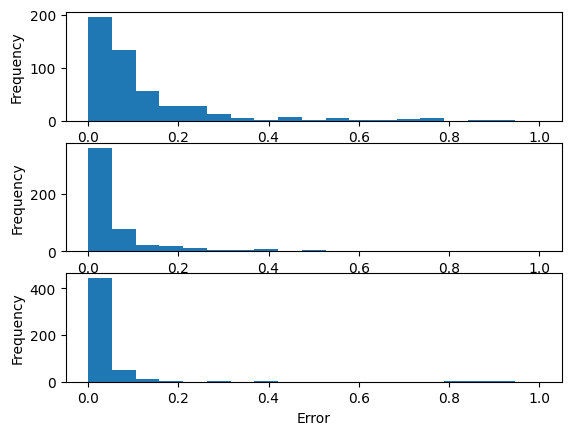

In [ ]:
epsilon = 1e-12
predictions = model.predict(eval_images)
plot_relative_errors(predictions, eval_tip_pos, epsilon, max_error=1, nbins=20)

...

We now calculate also mean and standard deviation of loss, absolute and euclidean errors:

In [ ]:
mean_absolute_errors = tf.keras.metrics.mean_absolute_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MAE: {np.mean(mean_absolute_errors)}')
print(f'Std of MAE: {np.std(mean_absolute_errors)}')

mean_euclidean_errors = mean_euclidean_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MEE: {np.mean(mean_euclidean_errors)}')
print(f'Std of MEE: {np.std(mean_euclidean_errors)}')

Mean of MAE: 0.0608697310090065
Std of MAE: 0.04630936309695244
Mean of MEE: 0.12754114758772384
Std of MEE: 0.09748981110525717


We calculate them also along each axis:

In [ ]:
distances = np.abs(eval_tip_pos - predictions)
print(f'Mean Distance along axes: {np.mean(distances, axis=0)}')
print(f'Std of Distance along axes: {np.std(distances, axis=0)}')

Mean Distance along axes: [0.09443581 0.04451944 0.04365395]
Std of Distance along axes: [0.09233133 0.04378708 0.05022803]


Now we save model and history:

In [ ]:
model.save('finetunedVGG165130NonRandomizedDatasetScaledlr2e-4')

In [ ]:
json.dump(history.history, open('finetunedVGG165130NonRandomizedDatasetScaledlr2e-4.json', 'w'))

In [ ]:
del model

##### With an extra hidden layer

In [ ]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
)
base_model.trainable = False

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
outputs = tf.keras.layers.Dense(3, activation='linear')(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               6422784   
                                                                 
 dense_3 (Dense)             (None, 3)                 771       
                                                                 
Total params: 21,138,243
Trainable params: 6,423,555
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
model.compile(
    loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4),
    metrics=['mean_absolute_error', mean_euclidean_error]
)

In [ ]:
history = model.fit(
    train_images, train_tip_pos, epochs=n_epochs,
    validation_data=(eval_images, eval_tip_pos),
    batch_size = batch_size, shuffle=True,
)

Epoch 1/100
48/48 [==============================] - 6s 93ms/step - loss: 26.9131 - mean_absolute_error: 3.7007 - mean_euclidean_error: 7.7344 - val_loss: 12.0184 - val_mean_absolute_error: 2.3600 - val_mean_euclidean_error: 5.2555
Epoch 2/100
48/48 [==============================] - 3s 62ms/step - loss: 6.6329 - mean_absolute_error: 1.7271 - mean_euclidean_error: 3.8044 - val_loss: 5.8105 - val_mean_absolute_error: 1.5900 - val_mean_euclidean_error: 3.5005
Epoch 3/100
48/48 [==============================] - 3s 73ms/step - loss: 3.2790 - mean_absolute_error: 1.1842 - mean_euclidean_error: 2.5979 - val_loss: 4.4976 - val_mean_absolute_error: 1.3469 - val_mean_euclidean_error: 3.0052
Epoch 4/100
48/48 [==============================] - 4s 77ms/step - loss: 2.2838 - mean_absolute_error: 0.9835 - mean_euclidean_error: 2.1560 - val_loss: 2.7485 - val_mean_absolute_error: 1.0304 - val_mean_euclidean_error: 2.2449
Epoch 5/100
48/48 [==============================] - 3s 64ms/step - loss: 1.63

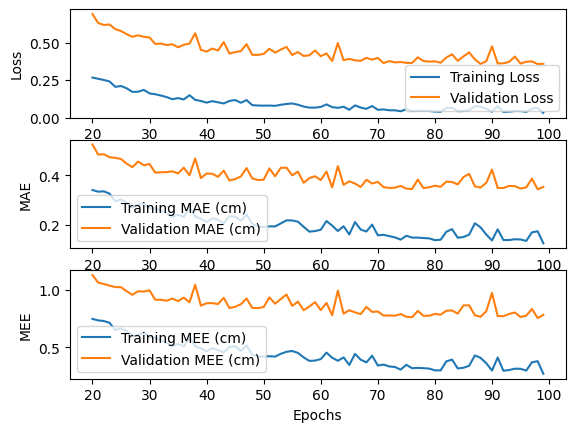

In [ ]:
plot_metrics(
    history, start_epoch=20, end_epoch=None,
    metrics=['loss', 'mean_absolute_error', 'mean_euclidean_error'],
    data_labels=[
        ('Training Loss', 'Validation Loss'), ('Training MAE (cm)', 'Validation MAE (cm)'),
        ('Training MEE (cm)', 'Validation MEE (cm)')
    ],
    axes_labels=[
        ('Epochs', 'Loss'), ('Epochs', 'MAE'), ('Epochs', 'MEE')
    ]
)

17/17 [==============================] - 1s 42ms/step
515 515 515
515 515 515
x-axis: mean = 0.510820548797737, std = 2.285752148737628
y-axis: mean = 0.11337691630874845, std = 0.6811535648834656
z-axis: mean = 0.010757411742558218, std = 0.015578945357859917


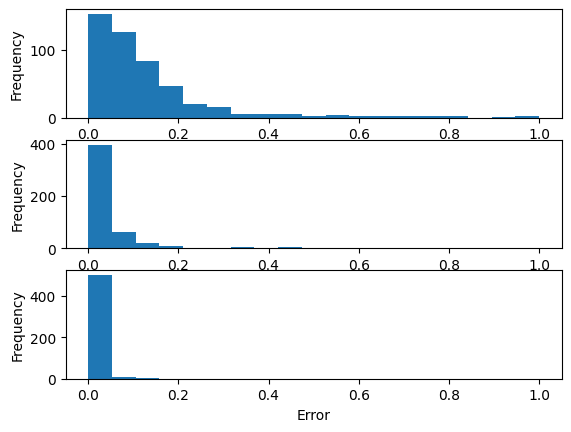

In [ ]:
epsilon = 1e-12
predictions = model.predict(eval_images)
plot_relative_errors(predictions, eval_tip_pos, epsilon, max_error=1, nbins=20)

...

We now calculate also mean and standard deviation of loss, absolute and euclidean errors:

In [ ]:
mean_absolute_errors = tf.keras.metrics.mean_absolute_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MAE: {np.mean(mean_absolute_errors)}')
print(f'Std of MAE: {np.std(mean_absolute_errors)}')

mean_euclidean_errors = mean_euclidean_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MEE: {np.mean(mean_euclidean_errors)}')
print(f'Std of MEE: {np.std(mean_euclidean_errors)}')

Mean of MAE: 0.35337501764297485
Std of MAE: 0.2831323742866516
Mean of MEE: 0.7831202537790257
Std of MEE: 0.6780410046731451


We calculate them also along each axis:

In [ ]:
distances = np.abs(eval_tip_pos - predictions)
print(f'Mean Distance along axes: {np.mean(distances, axis=0)}')
print(f'Std of Distance along axes: {np.std(distances, axis=0)}')

Mean Distance along axes: [0.68035546 0.20623312 0.17353632]
Std of Distance along axes: [0.68219711 0.19627302 0.18322237]


Now we save model and history:

In [ ]:
model.save('finetunedVGG165130NonRandomizedDatasetScaledlr2e-4_256hidden')

In [ ]:
json.dump(history.history, open('finetunedVGG165130NonRandomizedDatasetScaledlr2e-4_256hidden.json', 'w'))

In [ ]:
del model

#### VGG19

##### With a lower learning rate

In [ ]:
base_model = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
)
base_model.trainable = False

In [ ]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(3, activation='linear')(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 3)                 75267     
                                                                 
Total params: 20,099,651
Trainable params: 75,267
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
model.compile(
    loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4),
    metrics=['mean_absolute_error', mean_euclidean_error]
)

In [ ]:
history = model.fit(
    train_images, train_tip_pos, epochs=n_epochs,
    validation_data=(eval_images, eval_tip_pos),
    batch_size = batch_size, shuffle=True,
)

Epoch 1/100
48/48 [==============================] - 6s 95ms/step - loss: 57.7538 - mean_absolute_error: 6.0314 - mean_euclidean_error: 12.2352 - val_loss: 30.9647 - val_mean_absolute_error: 4.5959 - val_mean_euclidean_error: 9.0099
Epoch 2/100
48/48 [==============================] - 3s 73ms/step - loss: 21.1655 - mean_absolute_error: 3.5313 - mean_euclidean_error: 7.3767 - val_loss: 20.6064 - val_mean_absolute_error: 3.5561 - val_mean_euclidean_error: 7.3287
Epoch 3/100
48/48 [==============================] - 4s 83ms/step - loss: 14.6866 - mean_absolute_error: 2.7708 - mean_euclidean_error: 6.0124 - val_loss: 15.3779 - val_mean_absolute_error: 2.9060 - val_mean_euclidean_error: 6.1868
Epoch 4/100
48/48 [==============================] - 4s 86ms/step - loss: 11.3590 - mean_absolute_error: 2.3274 - mean_euclidean_error: 5.1703 - val_loss: 14.0262 - val_mean_absolute_error: 2.5979 - val_mean_euclidean_error: 5.7173
Epoch 5/100
48/48 [==============================] - 4s 75ms/step - los

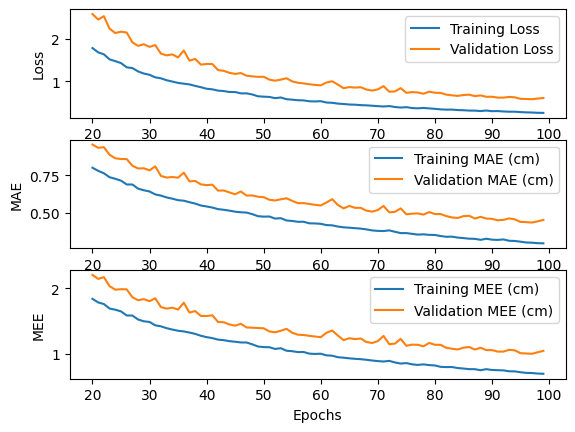

In [ ]:
plot_metrics(
    history, start_epoch=20, end_epoch=None,
    metrics=['loss', 'mean_absolute_error', 'mean_euclidean_error'],
    data_labels=[
        ('Training Loss', 'Validation Loss'), ('Training MAE (cm)', 'Validation MAE (cm)'),
        ('Training MEE (cm)', 'Validation MEE (cm)')
    ],
    axes_labels=[
        ('Epochs', 'Loss'), ('Epochs', 'MAE'), ('Epochs', 'MEE')
    ]
)

17/17 [==============================] - 1s 48ms/step
515 515 515
515 515 515
x-axis: mean = 0.49656236141875876, std = 1.874723364400917
y-axis: mean = 0.06381438247692221, std = 0.1930151455742984
z-axis: mean = 0.011772313537843313, std = 0.01626508749680227


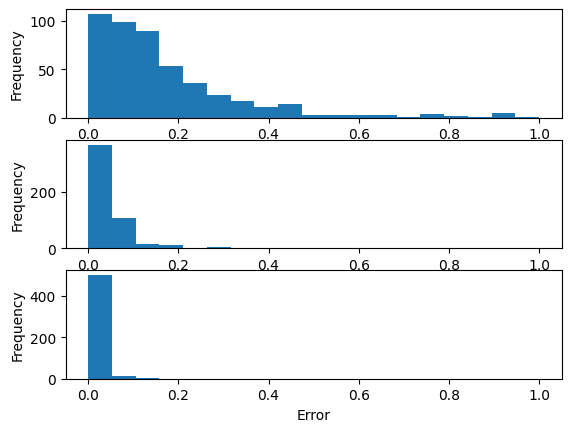

In [ ]:
epsilon = 1e-12
predictions = model.predict(eval_images)
plot_relative_errors(predictions, eval_tip_pos, epsilon, max_error=1, nbins=20)

...

We now calculate also mean and standard deviation of loss, absolute and euclidean errors:

In [ ]:
mean_absolute_errors = tf.keras.metrics.mean_absolute_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MAE: {np.mean(mean_absolute_errors)}')
print(f'Std of MAE: {np.std(mean_absolute_errors)}')

mean_euclidean_errors = mean_euclidean_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MEE: {np.mean(mean_euclidean_errors)}')
print(f'Std of MEE: {np.std(mean_euclidean_errors)}')

Mean of MAE: 0.4523305892944336
Std of MAE: 0.3352302610874176
Mean of MEE: 1.0485719872859716
Std of MEE: 0.8496697510684987


We calculate them also along each axis:

In [ ]:
distances = np.abs(eval_tip_pos - predictions)
print(f'Mean Distance along axes: {np.mean(distances, axis=0)}')
print(f'Std of Distance along axes: {np.std(distances, axis=0)}')

Mean Distance along axes: [0.94336084 0.22120858 0.19242241]
Std of Distance along axes: [0.87522608 0.20406926 0.19464751]


Now we save model and history:

In [ ]:
model.save('finetunedVGG165130NonRandomizedDatasetScaledlr2e-4_256hidden')

In [ ]:
json.dump(history.history, open('finetunedVGG165130NonRandomizedDatasetScaledlr2e-4_256hidden.json', 'w'))

In [ ]:
del model

##### With an extra hidden layer

In [ ]:
base_model = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
)
base_model.trainable = False

80134624/80134624 [==============================] - 3s 0us/step


In [ ]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
outputs = tf.keras.layers.Dense(3, activation='linear')(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 26,447,939
Trainable params: 6,423,555
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
model.compile(
    loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4),
    metrics=['mean_absolute_error', mean_euclidean_error]
)

In [ ]:
history = model.fit(
    train_images, train_tip_pos, epochs=n_epochs,
    validation_data=(eval_images, eval_tip_pos),
    batch_size = batch_size, shuffle=True,
)

Epoch 1/100
48/48 [==============================] - 17s 137ms/step - loss: 26.4905 - mean_absolute_error: 3.7210 - mean_euclidean_error: 7.7710 - val_loss: 11.9718 - val_mean_absolute_error: 2.3400 - val_mean_euclidean_error: 5.2500
Epoch 2/100
48/48 [==============================] - 4s 76ms/step - loss: 7.1133 - mean_absolute_error: 1.7479 - mean_euclidean_error: 3.9375 - val_loss: 6.9386 - val_mean_absolute_error: 1.7150 - val_mean_euclidean_error: 3.8778
Epoch 3/100
48/48 [==============================] - 4s 79ms/step - loss: 3.8552 - mean_absolute_error: 1.2642 - mean_euclidean_error: 2.8313 - val_loss: 3.9324 - val_mean_absolute_error: 1.2820 - val_mean_euclidean_error: 2.8649
Epoch 4/100
48/48 [==============================] - 4s 88ms/step - loss: 2.5430 - mean_absolute_error: 1.0149 - mean_euclidean_error: 2.2726 - val_loss: 2.8823 - val_mean_absolute_error: 1.0716 - val_mean_euclidean_error: 2.3819
Epoch 5/100
48/48 [==============================] - 4s 84ms/step - loss: 1.

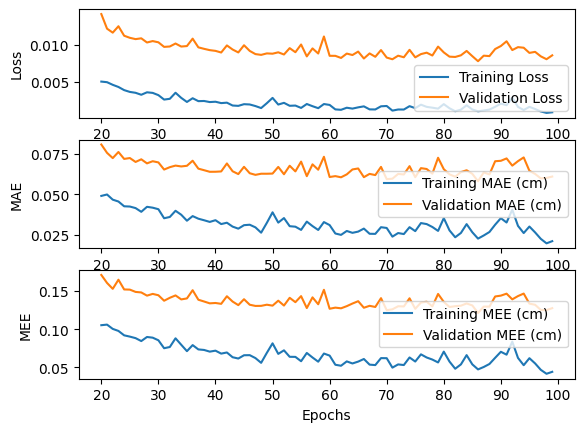

In [ ]:
plot_metrics(
    history, start_epoch=20, end_epoch=None,
    metrics=['loss', 'mean_absolute_error', 'mean_euclidean_error'],
    data_labels=[
        ('Training Loss', 'Validation Loss'), ('Training MAE (cm)', 'Validation MAE (cm)'),
        ('Training MEE (cm)', 'Validation MEE (cm)')
    ],
    axes_labels=[
        ('Epochs', 'Loss'), ('Epochs', 'MAE'), ('Epochs', 'MEE')
    ]
)

17/17 [==============================] - 1s 41ms/step
515 515 515
515 515 515
x-axis: mean = 0.3080799851227308, std = 1.3772086618026211
y-axis: mean = 0.0777265452065078, std = 0.17506317341001765
z-axis: mean = 0.03352185166566942, std = 0.08386000793628351


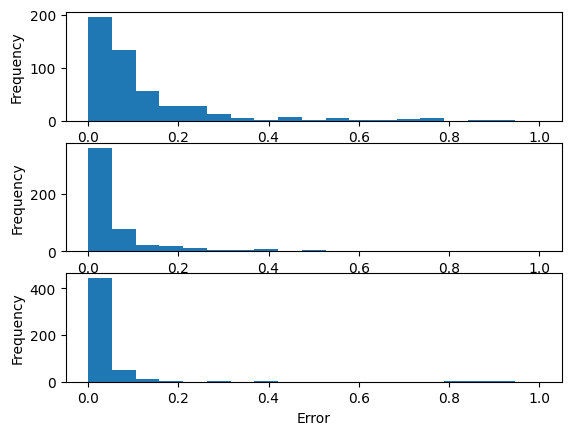

In [ ]:
epsilon = 1e-12
predictions = model.predict(eval_images)
plot_relative_errors(predictions, eval_tip_pos, epsilon, max_error=1, nbins=20)

...

We now calculate also mean and standard deviation of loss, absolute and euclidean errors:

In [ ]:
mean_absolute_errors = tf.keras.metrics.mean_absolute_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MAE: {np.mean(mean_absolute_errors)}')
print(f'Std of MAE: {np.std(mean_absolute_errors)}')

mean_euclidean_errors = mean_euclidean_error(eval_tip_pos, predictions).numpy()
print(f'Mean of MEE: {np.mean(mean_euclidean_errors)}')
print(f'Std of MEE: {np.std(mean_euclidean_errors)}')

Mean of MAE: 0.0608697310090065
Std of MAE: 0.04630936309695244
Mean of MEE: 0.12754114758772384
Std of MEE: 0.09748981110525717


We calculate them also along each axis:

In [ ]:
distances = np.abs(eval_tip_pos - predictions)
print(f'Mean Distance along axes: {np.mean(distances, axis=0)}')
print(f'Std of Distance along axes: {np.std(distances, axis=0)}')

Mean Distance along axes: [0.09443581 0.04451944 0.04365395]
Std of Distance along axes: [0.09233133 0.04378708 0.05022803]


Now we save model and history:

In [ ]:
model.save('finetunedVGG165130NonRandomizedDatasetScaledlr2e-4_256hidden')

In [ ]:
json.dump(history.history, open('finetunedVGG165130NonRandomizedDatasetScaledlr2e-4_256hidden.json', 'w'))

In [ ]:
del model